<a href="https://colab.research.google.com/github/Maloepf/DataModels_Lab1/blob/main/LabAssignmentRNNsToyTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing Sequences Using RNNs (and CNNs)

*Credits:* Based on code written by [A. Géron](https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb#scrollTo=AiINDLJHVNep) for his "Hands-on ML" book. Code realeased under [Apache 2.0 license](https://github.com/ageron/handson-ml2/blob/master/LICENSE).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In this activity we are going to explore different ways of modelling sequential data. We will try out simple baseline models as well as 1D CNNs and different RNNs to **forecast the next step in a time series**.

## Generating sample data

To experiment with different models, we'll use some randomly generated univariate time series.



In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)

Notice the shape of the series array:


In [4]:
series.shape

(10000, 51, 1)

The meaning of each dimension is `[samples, time steps, sequence element size]`.
Here each series element is a single scalar because we are making a univariate prediction.
If we were modeling mutiple time series at once (eg. temperature and humidity) this would be a multi-variate prediction and our sequence element size would be 2.

### Creating predicion targets
We want to predict one step further into the series. To do so , we can take the last time step of a series as the regression target, while using all the previous time steps as inputs.

We also want to split our data into train, validation and test sets as usual.

In [5]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [6]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

### Visualizing the data
This function plots the first series samples from a given batch, along with the next predicted value.

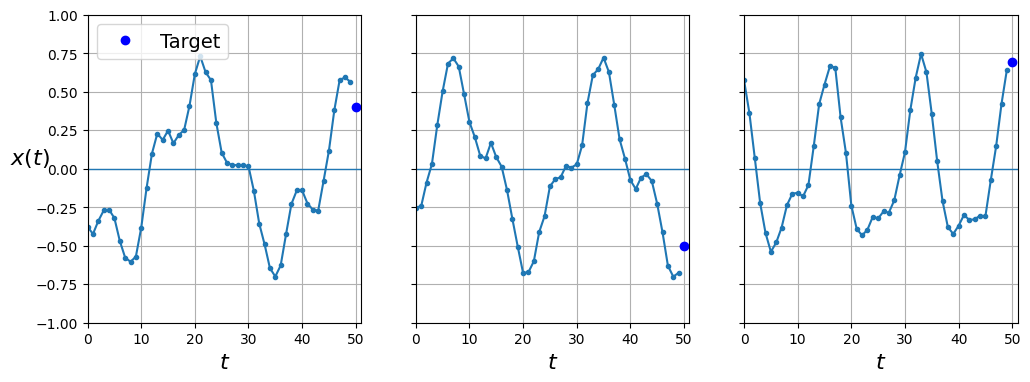

In [7]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

## Prediction task 1 : forecast one time step

We want to predict a single continuous value for each input sequence. This can be seen as a sequence-to-vector regression task. As seen in class, a suitable loss function is the `keras.losses.mean_squared_error` (as derived by MLE under a Gaussian assumption on the prediciton targets).


As we try out different models, keep the models and their validation performances. In the end you will compare their performances in validation to pick the best model (which will be applied to the test set).


### Simple baseline models

Before trying complex models, it is important to set up a baseline performance obtained with a simple model. This way we will only be interested in the more complex models if they do better than our baseline.

#### Baseline 1: Naive baseline

Our first baseline will follow a very simple rule: predict the series will not change. That means the output will be a repetition of the series value at the last observed time step.

This is very simple to implement: our predictions `y_pred` will simply be equal to the last time step in the `X` array.



##### TODO: write the naive baseline code bellow
Compute the naive predictions on the validation set and save them to a `y_pred` array.

In [25]:
y_pred = X_valid[:,-1]

Here is the first series in the validation set with its predicted value:

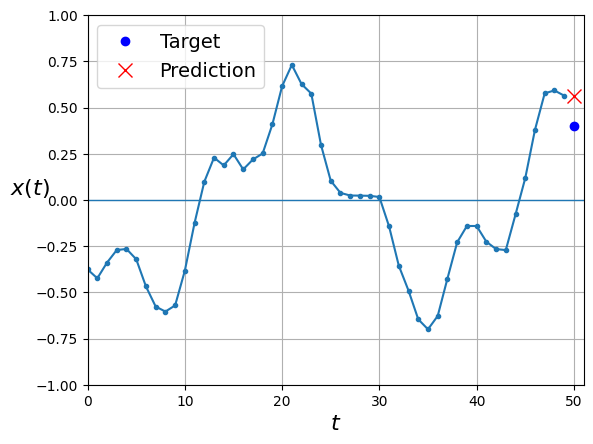

In [26]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### Baseline 2: linear baseline

Our second basline model will be a linear regression. We can implement it using keras `Sequential` API by simply using a `Dense` layer with no activation functions.



##### TODO: write a linear regression model using a Dense layer
- Don't forget to use `Flatten` and define the expected input shape using the keyword argument `input_shape`


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

np.random.seed(42)
tf.random.set_seed(42)

def create_linear_regression_model(input_shape):
  model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(1)
  ])

  return model

model_baseline_2=create_linear_regression_model(X_train.shape[1:])
model_baseline_2.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51 (204.00 B)

 Trainable params: 51 (204.00 B)

 Non-trainable params: 0 (0.00 B)

This model has parameters to train: we will call `fit` to learn them.

##### TODO: train the linear regression model
 - Use the Adam optimizer with the default learning rate
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2790 - val_loss: 0.0485
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0377 - val_loss: 0.0205
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - val_loss: 0.0119
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0087
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

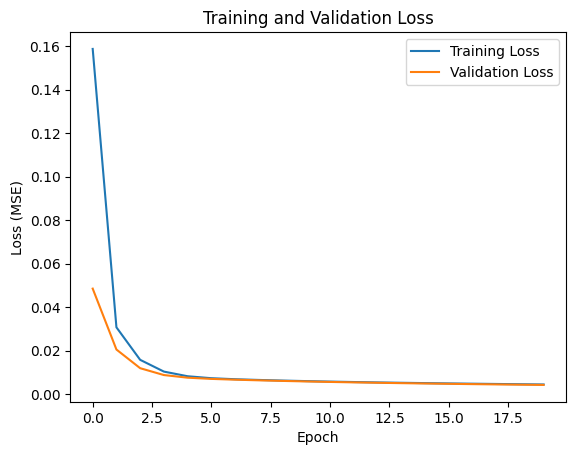

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040  
Validation MSE: 0.004179316572844982


In [38]:
from tensorflow.keras.optimizers import Adam

model_baseline_2.compile(optimizer=Adam(), loss='mse')

history = model_baseline_2.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=20,
    verbose=1
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate performance on the validation set
val_loss = model_baseline_2.evaluate(X_valid, y_valid, verbose=1)
print(f'Validation MSE: {val_loss}')

### Recurrent models

#### Model 1: Simple RNN
Our first recurrent model will use simple recurrent units. You can implement it using the built-in `keras.layers.SimpleRNN`.

Here again we will specify the expected input shape (ignoring the batch dimension). We want the time-steps dimension to be variable: thus we set it to `None`. The sequence element dimension continues to be 1.

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model_rnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

##### TODO: train the simple RNN model
 - Use the Adam optimizer with the a learning rate of 1e-5
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0214 - val_loss: 0.0209
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0211 - val_loss: 0.0207
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0209 - val_loss: 0.0204
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0207 - val_loss: 0.0202
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0204 - val_loss: 0.0200
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0202 - val_loss: 0.0198
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0200 - val_loss: 0.0196
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0198 - val_loss: 0.0194
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0196 - val_loss: 0.0192
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0194 - val_loss: 0.0190
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0192 - val_loss: 0.0188
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/

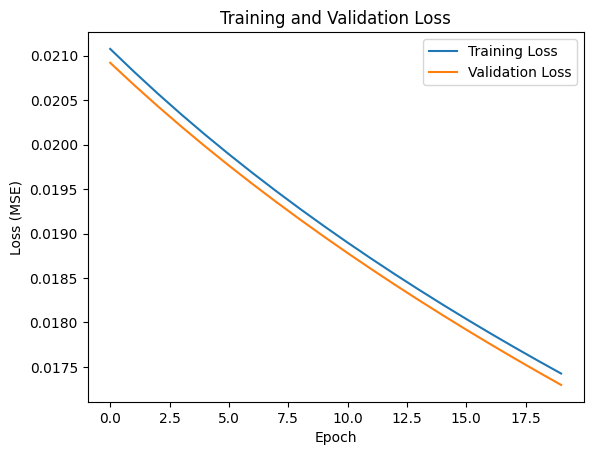

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170
Validation MSE: 0.017296982929110527


In [43]:
model_rnn.compile(optimizer=Adam(learning_rate=1e-5),loss='mse')

history = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=20,
    verbose=1
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate performance on the validation set
val_loss = model_rnn.evaluate(X_valid, y_valid, verbose=1)
print(f'Validation MSE: {val_loss}')

#### Model 2: Deep simple RNN
This time we will use multiple recurrent layers in our model. The final output will be computed with a dense layer.


##### Chaining two RNN layers
Notice that while recurrent layers expect sequence inputs with 3 dimensions (samples, time, element size), they output by default 2 D data as in `[samples, predicted element size]`.

If you chain two RNN layers, the first one needs yield sequence-shaped outputs (with the 3 dimensions) so that it is compatible with the second layer. In this case, the layer needs to be declared with the keywork argument `return_sequences=True`.

##### TODO: Create a Deep RNN with 2 hidden recurrent layers
- Use two simple RNN layers with 20 units
- Compute the final output doing a linear read-out (use a Dense layer with no activation)

In [44]:
np.random.seed(42)
tf.random.set_seed(42)


model_rnn_2hiddenlayer = keras.models.Sequential([
    keras.layers.SimpleRNN(20, input_shape=[None, 1], return_sequences=True),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model_rnn_2hiddenlayer.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, None, 20)            │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

##### TODO: train the Deep RNN model
 - Use the Adam optimizer with the default learning rate
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.1107 - val_loss: 0.0058
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━

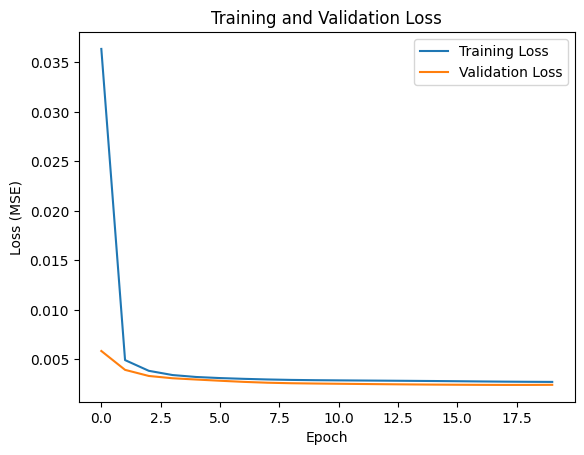

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146
Validation MSE: 0.01483958214521408


In [47]:
model_rnn_2hiddenlayer.compile(optimizer=Adam(),loss='mse')

history = model_rnn_2hiddenlayer.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=20,
    verbose=1
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate performance on the validation set
val_loss = model_rnn.evaluate(X_valid, y_valid, verbose=1)
print(f'Validation MSE: {val_loss}')

### TODO: Final comparison and model choice
Compare the compare performances of different models in validation to pick the best model.
Apply it to the test set and evaluate it: is the performance close to what you got in the validation set?

In [51]:
test_loss = model_rnn_2hiddenlayer.evaluate(X_test,y_test,verbose=1)
val_loss = history.history['val_loss'][-1]


print(f'The model with the best val_loss result, is model_rnn_2hiddenlayer.\n'
      f'Test Loss for model_rnn_2hiddenlayer: {test_loss}\n'
      f'Validation Loss: {val_loss}\n'
      f'Test Loss: {test_loss}\n'
      f'Difference between Validation and Test Loss: {abs(val_loss - test_loss)}'
)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
The model with the best val_loss result, is model_rnn_2hiddenlayer.
Test Loss for model_rnn_2hiddenlayer: 0.0025727180764079094
Validation Loss: 0.0024317163042724133
Test Loss: 0.0025727180764079094
Difference between Validation and Test Loss: 0.00014100177213549614


## Prediction task 2: forecast multiple time steps

This task can be formulated as a sequence-to-sequence task if we predict one output timstep at a time. But we can also formulate it as a sequence-to-vector task, in which we try to predict all time steps at once.

### Method 1: Predicting 1 step at a time (seq2vec)


We'll use the previous model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [52]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one. We will keep using tha previous output as new input until we predict 10 values.

In [53]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [54]:
Y_pred.shape

(2000, 10)

#### TODO: check the loss value (MSE) for this method

In [58]:
from sklearn.metrics import mean_squared_error

mean_squared_error(Y_valid, Y_pred)

1.1125633

#### Plot multiple forecasts
Use this plotting function to visualize your input series and the output predictions.

**Attention**: Reshape the outputs of your models acordingly:
If you model outputs 2D arrays with shape [batch size, time steps], you can use `Y[..., np.newaxis]` or `np.expand_dims(Y, shape=-1) ` to make them compatible with this function.

In [60]:
def plot_multiple_forecasts(X, Y, Y_pred):
    # X should be a rank 3 array with shapes [batch size, sequence length, 1]
    # Y and y_pred should also be rank 3 with shape [0, sequence lenght, 1]
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


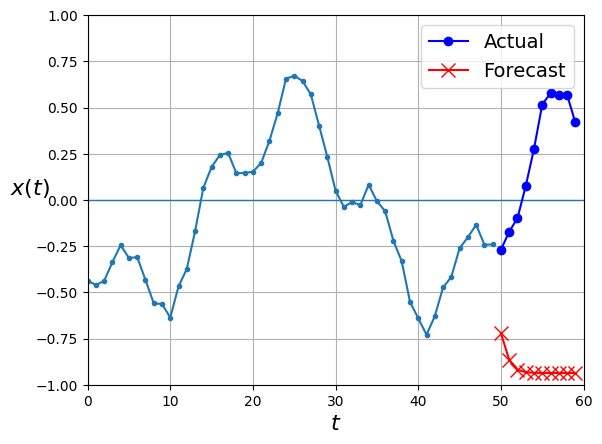

In [68]:
plot_multiple_forecasts(X_valid, Y_valid[..., np.newaxis], Y_pred[..., np.newaxis])
plt.show()

#### TODO: Baselines: naive and linear prediction

Implement the naive and the linear baselines folowing this method to predict the next 10 steps. Compare their performances to the previous RNN model.

In [83]:
X_naive = X_valid.copy()

for step_ahead in range(10):
    y_pred_one = X_naive[:, -1, 0]

    y_pred_one = y_pred_one[:, np.newaxis, np.newaxis]

    X_naive = np.concatenate([X_naive, y_pred_one], axis=1)

Y_pred_naive = X_naive[:, n_steps:, 0]


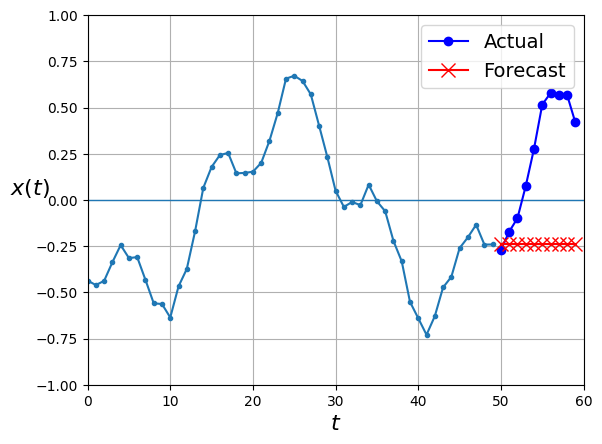

In [84]:
plot_multiple_forecasts(X_valid, Y_valid[..., np.newaxis], Y_pred_naive[..., np.newaxis])
plt.show()

In [90]:
# Linear baseline prediction: use the linear trend of the last two values to predict the next one
X_linear = X_valid.copy()  # Start with the validation data

for step_ahead in range(10):
    # Use the last two values (last time steps) to predict the next value
    last_value = X_linear[:, -1, 0]  # The last observed value
    second_last_value = X_linear[:, -2, 0]  # The second last value

    # Linear extrapolation (difference between last two values)
    y_pred_one = last_value + (last_value - second_last_value)  # Linear extrapolation

    # Reshape y_pred_one to have shape (samples, 1, 1)
    y_pred_one = y_pred_one[:, np.newaxis, np.newaxis]  # Reshaping to (samples, 1, 1)

    # Append the predicted value to the sequence
    X_linear = np.concatenate([X_linear, y_pred_one], axis=1)  # Concatenate along the time axis (axis=1)

# Extract predicted values for the next 10 steps
Y_pred_linear = X_linear[:, n_steps:, 0]  # Get the predicted next 10 values


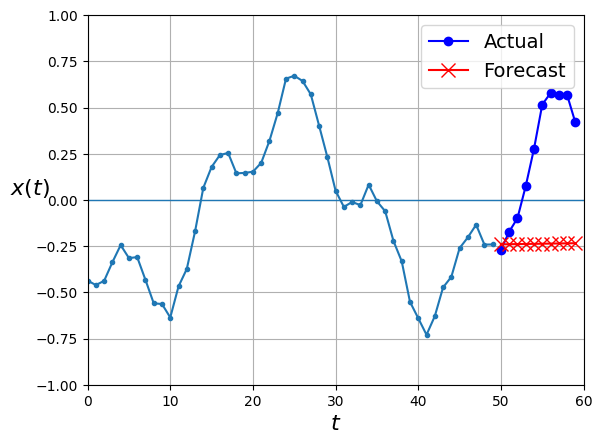

In [91]:
plot_multiple_forecasts(X_valid, Y_valid[..., np.newaxis], Y_pred_linear[..., np.newaxis])
plt.show()

### Method 2A: Predicting 10 steps at once at the end (seq2vec)

In this section we wil predict all 10 steps at once as a vector output at the end of the input sequence processing. Intermediate network outputs will be ignored.

#### Model 1: Deep simple RNN with output prediction at the end

Let's create an RNN that predicts all 10 next values at once. To do that, all you need is to change the size of the final `Dense` layer to 10.

##### TODO: build the new RNN model with output size = 10
- Use two simple RNN layers with 20 units
- Compute the final output doing a linear read-out (use a Dense layer with no activation)

In [92]:
np.random.seed(42)
tf.random.set_seed(42)

model_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, input_shape=[None,1], return_sequences=True),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model_rnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)             │ (None, None, 20)            │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_6 (SimpleRNN)             │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,470 (5.74 KB)

 Trainable params: 1,470 (5.74 KB)

 Non-trainable params: 0 (0.00 B)

##### TODO: train the Deep RNN model
 - Use the Adam optimizer with the default learning rate
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.1117 - val_loss: 0.0535
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0513 - val_loss: 0.0419
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0405 - val_loss: 0.0325
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0336 - val_loss: 0.0296
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0309 - val_loss: 0.0282
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0293 - val_loss: 0.0273
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0282 - val_loss: 0.0265
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0272 - val_loss: 0.0257
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0262 - val_loss: 0.0250
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0254 - val_loss: 0.0246
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0243 - val_loss: 0.0229
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

Text(0, 0.5, 'Loss (MSE)')

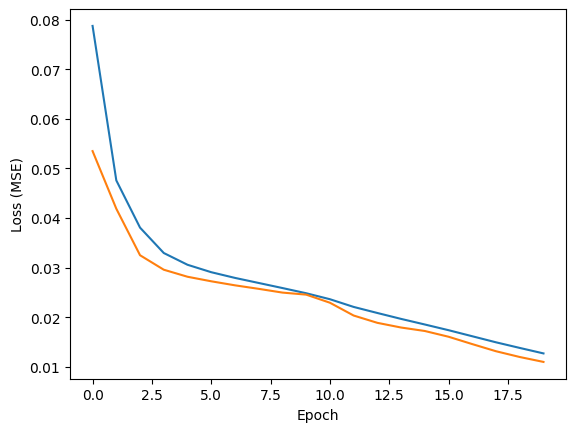

In [93]:
# Training the model

model_rnn.compile(optimizer=Adam(), loss='mse')

history = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=20,
    verbose=1
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


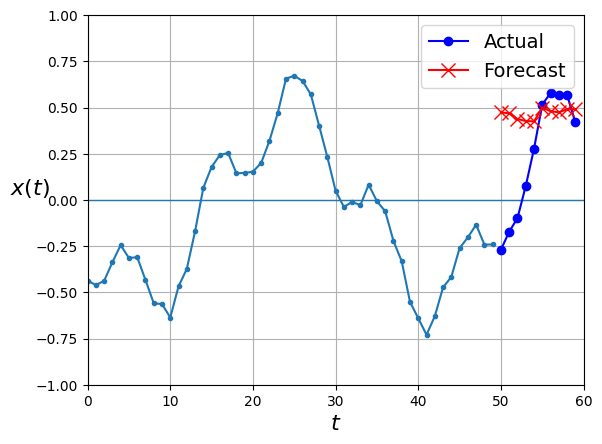

In [94]:
Y_pred = model_rnn.predict(X_valid)

Y_valid = Y_valid[..., np.newaxis]
Y_pred = Y_pred[..., np.newaxis]

plot_multiple_forecasts(X_valid, Y_valid, Y_pred)

### Method 2B: Predicting 10 steps at once at every time step (seq2seq)

Now let's create RNN models that predict the next 10 steps at each time step.

This means that at t=0, the model predicts a vector with time steps t=1 to 1=10. Then as t=1, it predcits another vector with t=2 to t=11, and so on, until the end of the series.

A crucial difference here is that for each time step we expect a prediction, while before we only cared about the last output. This implies that the loss will contain a term for each time step, not just the last. This way, during backpropagation, each time-step will contribute with a gradient term flowing back, not only though time but also within the same time step. In practice, this is likely to stabilize AND speed-up training.


**Note:** In this model and all others used here, predictions for time $T$ only take into account past series values, i.e. where $t < T$. This defines them as a *causal* models.

#### Generating appropriate data and prediciton targets

For this method we'll "collect" more data, generating longer series with extra 10 steps.

We also need to generate the corresponting target array, which should contain 10-D vectors for all time steps $t>0$.

In [95]:
np.random.seed(42)

n_steps = 50
# generate data with extra 10 steps
series = generate_time_series(10000, n_steps + 10)

# prep input arrays
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

# generate target arrays using the last 10 steps
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [96]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

#### Custom loss function

All outputs are needed during training, but only the output at the last time step is useful at inference time for predictions and evaluation.
So eve though we will rely on the MSE over all the outputs for training, we will use a custom metric for evaluation, to compute MSE only over the output at the last time step:

In [97]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

#### TODO Model 2: Deep simple RNN with output prediction at every timestep
- Use two simple RNN layers with 20 units
- Compute the final output doing a linear read-out (use a Dense layer with no activation)

In [100]:
np.random.seed(42)
tf.random.set_seed(42)

model_rnn_output_each_timestep = Sequential([
    keras.layers.SimpleRNN(20, input_shape=[None, 1], return_sequences=True),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(Dense(1))
])

model_rnn_output_each_timestep.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)             │ (None, None, 20)            │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_10 (SimpleRNN)            │ (None, None, 20)            │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, None, 1)             │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

##### TODO: train the Deep RNN model
 - Use the Adam optimizer with the default learning rate
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.0855 - val_loss: 0.0847
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0850 - val_loss: 0.0845
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0850 - val_loss: 0.0844
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0849 - val_loss: 0.0844
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0848 - val_loss: 0.0843
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0847 - val_loss: 0.0843
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0846 - val_loss: 0.0842
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0845 - val_loss: 0.0841
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0845 - val_loss: 0.0841
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0843 - val_loss: 0.0840
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0842 - val_loss: 0.0839
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━

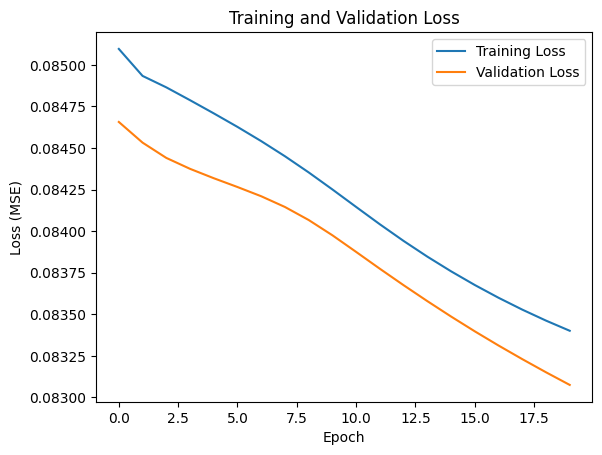

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0834
Validation MSE: 0.08307483792304993
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


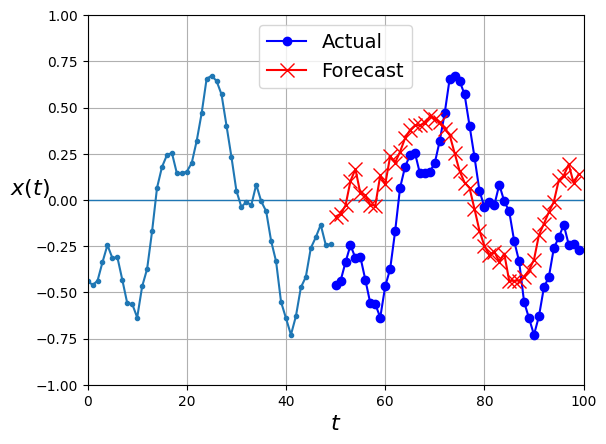

In [103]:

model_rnn_output_each_timestep.compile(optimizer=Adam(), loss="mse")

history = model_rnn_output_each_timestep.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=20,
    verbose=1
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate performance on the validation set
val_loss = model_rnn_output_each_timestep.evaluate(X_valid, Y_valid, verbose=1)
print(f'Validation MSE: {val_loss}')

# Generate predictions for the validation set
Y_pred = model_rnn_output_each_timestep.predict(X_valid)

# Call the plot_multiple_forecasts function
plot_multiple_forecasts(X_valid, Y_valid, Y_pred)
plt.show()

#### TODO Model 3: Deep LSTM with output prediction at every timestep

- Use two LSTM layers with 20 units
- Compute the final output doing a linear read-out (use a Dense layer with no activation)

In [106]:
np.random.seed(42)
tf.random.set_seed(42)

model_lstm = Sequential([
    keras.layers.LSTM(20, input_shape=[None, 1], return_sequences=True),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(Dense(1))
])

model_lstm.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 20)            │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 20)            │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, None, 1)             │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

##### TODO: train the Deep RNN model
 - Use the Adam optimizer with the default learning rate
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 0.1110 - val_loss: 0.0961
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0957 - val_loss: 0.0935
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0937 - val_loss: 0.0921
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.0915 - val_loss: 0.0898
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0895 - val_loss: 0.0880
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0884 - val_loss: 0.0872
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0877 - val_loss: 0.0866
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0871 - val_loss: 0.0861
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0866 - val_loss: 0.0858
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0863 - val_loss: 0.0854
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 0.0859 - val_loss: 0.0851
Epoch 12/20
219/219 ━━━━━━━━━━━━

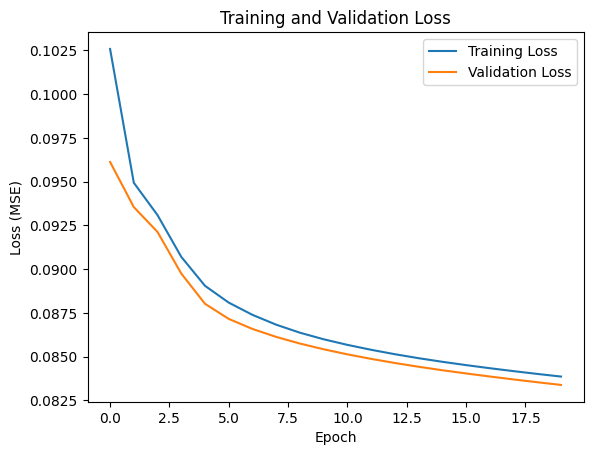

In [107]:
# Training the model

model_lstm.compile(optimizer=Adam(), loss="mse")

history = model_lstm.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=20,
    verbose=1
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0837
Validation MSE: 0.08338797092437744
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


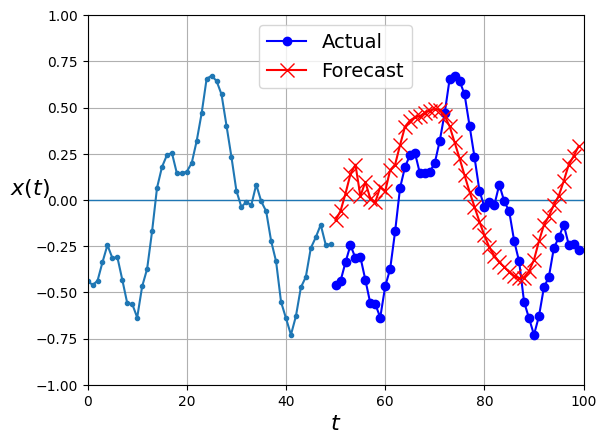

In [109]:
# Evaluate performance on the validation set
val_loss = model_lstm.evaluate(X_valid, Y_valid, verbose=1)
print(f'Validation MSE: {val_loss}')

Y_pred = model_lstm.predict(X_valid)
plot_multiple_forecasts(X_valid, Y_valid, Y_pred)
plt.show()

#### TODO Model 4: Deep GRU with output prediction at every timestep
- Use two GRU layers with 20 units
- Compute the final output doing a linear read-out (use a Dense layer with no activation)

In [110]:
np.random.seed(42)
tf.random.set_seed(42)


model_gru = Sequential([
    keras.layers.GRU(20, input_shape=[None, 1], return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(Dense(1))
])

model_gru.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, None, 20)            │           1,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, None, 20)            │           2,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, None, 1)             │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,921 (15.32 KB)

 Trainable params: 3,921 (15.32 KB)

 Non-trainable params: 0 (0.00 B)

##### TODO: train the Deep RNN model
 - Use the Adam optimizer with the default learning rate
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - loss: 0.1146 - val_loss: 0.0981
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 0.0987 - val_loss: 0.0970
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - loss: 0.0972 - val_loss: 0.0935
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.0929 - val_loss: 0.0900
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 0.0898 - val_loss: 0.0882
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 0.0881 - val_loss: 0.0873
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - loss: 0.0869 - val_loss: 0.0861
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 0.0862 - val_loss: 0.0855
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 0.0858 - val_loss: 0.0852
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 0.0855 - val_loss: 0.0849
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 0.0852 - val_loss: 0.0847
Epoch 12/20
219/219 ━━━━━━━━━━

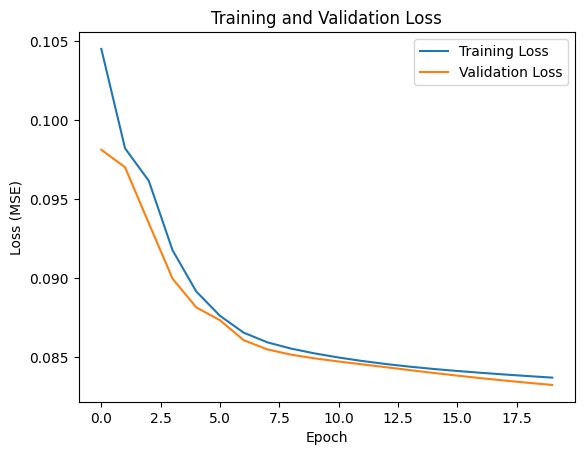

In [111]:
# Training the model

model_gru.compile(optimizer=Adam(), loss="mse")

history = model_gru.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=20,
    verbose=1
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0837
Validation MSE: 0.08338797092437744
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


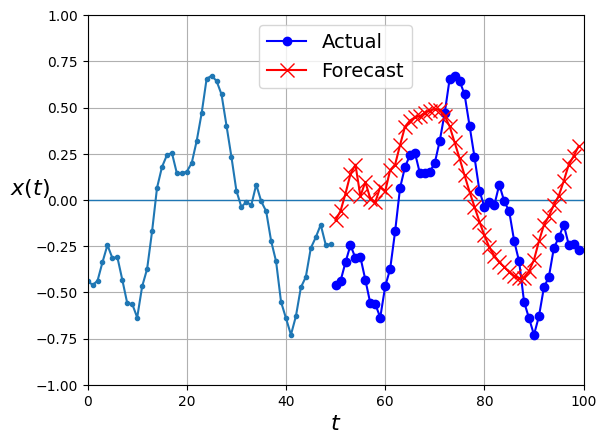

In [112]:
# Evaluate performance on the validation set
val_loss = model_lstm.evaluate(X_valid, Y_valid, verbose=1)
print(f'Validation MSE: {val_loss}')

Y_pred = model_lstm.predict(X_valid)
plot_multiple_forecasts(X_valid, Y_valid, Y_pred)
plt.show()

### TODO: Model comparison for prediction task 2

Create a summary table with the validation performaces of all models used in this secont task. Choose the best of them and evaluate it on the test set. Did it generalize as well as predicted by the validation score?

## Extra models

Sequences can be treated with convolutional layers as we'll see in class soon. Here are two example models applied to the time series data we have used in this notebook.

#### Generating appropriate data and prediciton targets

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

#### Model 5: 1D convolution + GRUs
**Attention** Due to using a convolution stride of 2, the convolutional layer subsamples the input series by a factor of 2. That means that the predicted outputs will be related to the prediction targets with a similar subsampling factor.

Additionally, the kernel size of 4 in combination with using a valid convolution makes that the first predicted output corresponds to the 4th time-steps.

This means you should compare your predictions to a cropped and subsampled version of the targets array, as follows:
```
subsampled_target = target[:, 3::2]
```

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

##### TODO: train the conv + GRU model
 - Use the Adam optimizer with the default learning rate
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set




#### Model 6: WaveNet-like model
![Wavenet diagram](http://benanne.github.io/images/wavenet.png)
[From Oord et al., 2016](https://arxiv.org/abs/1609.03499)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.summary()

##### TODO: train the WaveNet model
 - Use the Adam optimizer with the default learning rate
 - Train it it for 20 epochs
 - Don't forget to include your validation data
 - Check the learning curves and the performance on the validation set